### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
from sentence_transformers import SentenceTransformer
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy import spatial
from tqdm import tqdm
import seaborn as sns
import nltk
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score
import matplotlib.pyplot as plt
import gensim
from gensim.models import word2vec,KeyedVectors
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import MinMaxScaler

In [ ]:
pip install tqdm  

Note: you may need to restart the kernel to use updated packages.


'C:\Users\fahan\Program' is not recognized as an internal or external command,
operable program or batch file.


### Reading file and preprocessing

In [ ]:
data = pd.read_csv("C:/Users/fahan/Desktop/CENTELLA/NLP/NLP/data/file_information.csv")
data.head()

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light
3,g0pA_taskd.txt,d,heavy
4,g0pA_taske.txt,e,non


In [ ]:
numerical_categories = {'non': 0, 'heavy': 1, 'light': 2, 'cut': 3, 'orig': -1}

for key, val in numerical_categories.items():
    data = data.replace(key, val)
        
# add class labels 
data['Class'] = np.where(data['Category'] != 0, 1, 0) # label whether plagiarized (1) or not (0)
data['Class'] = np.where(data['Category'] == -1, -1, data['Class']) # -1 category is origin => class is -1 (meaningless)

In [ ]:
def process_file(file):
    # put text in all lower case letters 
    all_text = file.read().lower()

    # remove all non-alphanumeric chars
    all_text = re.sub(r"[^a-zA-Z0-9]", " ", all_text)
    # remove newlines/tabs, etc. so it's easier to match phrases, later
    all_text = re.sub(r"\t", " ", all_text)
    all_text = re.sub(r"\n", " ", all_text)
    all_text = re.sub("  ", " ", all_text)
    all_text = re.sub("   ", " ", all_text)
    
    return all_text

In [ ]:
#Add processed text as a new column
texts = []
for index, row in data.iterrows():
    filename = 'data/'+row['File']
    with open(filename, 'r', encoding='utf-8', errors='ignore') as fh:
        processed_text = process_file(fh)
        texts.append(processed_text)
data['Text'] = texts

In [ ]:
data.head()

,File,Task,Category,Class,Text
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,2,1,the vector space model also called term vector...
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...


In [ ]:
orig = data[data['Class'] == -1]
answers = data[data['Class']!=-1]

In [ ]:
answers.shape

(95, 5)

### Split answers to training and test data

In [ ]:

X = answers.drop(columns='Class')
y = answers['Class']
bert_train_X,bert_test_X,bert_train_y,bert_test_y = train_test_split(X,y,test_size=0.3,stratify=y,random_state=10)

### Applying BERT model

In [ ]:
bert_model = SentenceTransformer('all-mpnet-base-v2')

In [ ]:

a = bert_model.encode(data['Text'].iloc[1])
a

array([ 4.25828546e-02, -8.88934508e-02, -3.23065817e-02, -3.83634726e-03,
       -2.62154043e-02,  1.37858596e-02, -3.99733856e-02,  2.00609746e-03,
        1.00462236e-01, -5.06738536e-02,  1.80663075e-02,  1.89659111e-02,
       -1.80670631e-03,  9.51961428e-03,  5.58866039e-02, -4.48407605e-02,
        4.11355468e-05,  3.88601460e-02,  8.49447315e-05, -6.58433652e-03,
        6.40291302e-03, -8.86661746e-03, -1.36963176e-02, -2.59271599e-02,
        8.78234804e-02,  1.74623616e-02,  1.35190459e-03,  1.29138166e-02,
        1.86685771e-02, -5.66171035e-02, -6.96916282e-02, -2.91657029e-03,
       -3.75076197e-02, -2.45289668e-03,  1.80585357e-06, -3.73741686e-02,
       -1.96432229e-02, -4.36710473e-03,  1.85594428e-02,  7.84407463e-03,
       -2.31536049e-02,  4.42034416e-02,  1.92052890e-02,  2.61568911e-02,
       -1.25973136e-03,  1.23287290e-02, -1.64974220e-02,  1.95699409e-02,
        7.21555669e-03,  5.32604707e-03,  2.19435506e-02, -3.40855643e-02,
        7.88225420e-03,  

In [ ]:
orig.head()

,File,Task,Category,Class,Text
95,orig_taska.txt,a,-1,-1,in object oriented programming inheritance is ...
96,orig_taskb.txt,b,-1,-1,pagerank is a link analysis algorithm used by ...
97,orig_taskc.txt,c,-1,-1,vector space model or term vector model is an ...
98,orig_taskd.txt,d,-1,-1,in probability theory bayes theorem often call...
99,orig_taske.txt,e,-1,-1,in mathematics and computer science dynamic pr...


In [ ]:
1-spatial.distance.cosine(bert_model.encode(data['Text'].iloc[1]), bert_model.encode(orig['Text'].iloc[1]))

0.940191388130188

In [ ]:
bert_encode_answers=[]
for i in range(len(bert_train_X)):
    bert_encode_answers.append(bert_model.encode(bert_train_X['Text'].iloc[i]))


In [ ]:
bert_encode_answers[1].shape

(768,)

In [ ]:
bert_encode_orig=[]
for i in range(len(orig)):
    bert_encode_orig.append(bert_model.encode(orig['Text'].iloc[i]))


In [ ]:
bert_encode_orig[1].shape

(768,)

In [ ]:
def similarity(query,source,i,j):
    sm=1-spatial.distance.cosine(bert_model.encode(query['Text'].iloc[i]), bert_model.encode(source['Text'].iloc[j]))
    return sm

In [ ]:
similarity(answers,orig,4,1)

0.21815869212150574

In [ ]:
simarray=np.empty((len(bert_train_X),len(orig)))
for i in (range(len(orig))):
    for j in tqdm(range(len(bert_train_X))):
        simarray[j][i]=similarity(bert_train_X,orig,j,i)

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [02:32<00:00,  2.32s/it]


In [ ]:
simarray

array([[0.18477127, 0.18365739, 0.18945044, 0.10940931, 0.71988475],
       [0.90128958, 0.15312842, 0.21460237, 0.20882605, 0.32205972],
       [0.34705085, 0.20143943, 0.2131864 , 0.19274242, 0.88324577],
       [0.08678155, 0.11612173, 0.11809544, 0.78165698, 0.11825684],
       [0.15584539, 0.72701257, 0.2219682 , 0.19096008, 0.2257304 ],
       [0.3971563 , 0.18336025, 0.2169265 , 0.18308501, 0.96939552],
       [0.28369892, 0.41623902, 0.74867159, 0.18995479, 0.16660236],
       [0.24316549, 0.37969923, 0.87130082, 0.25337055, 0.18292151],
       [0.14562142, 0.79129899, 0.31164297, 0.08123633, 0.21637394],
       [0.29593804, 0.19046456, 0.17246453, 0.19648427, 0.94150066],
       [0.22154559, 0.09362184, 0.19759585, 0.88287824, 0.14622128],
       [0.94916499, 0.18740727, 0.27326822, 0.23726234, 0.37841254],
       [0.86381888, 0.09836773, 0.14214775, 0.21716377, 0.30103871],
       [0.20897232, 0.64334059, 0.36233023, 0.08916252, 0.16539352],
       [0.19757378, 0.82675433, 0.

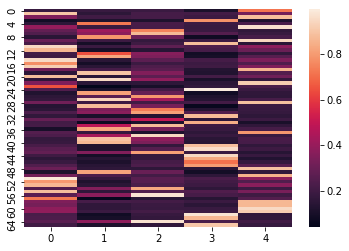

In [ ]:
ax=sns.heatmap(simarray)

In [ ]:
maxsim = simarray.max(axis=1)

In [ ]:
plagsim = maxsim[np.where(bert_train_y==1)]

In [ ]:
plagsim

array([0.90128958, 0.88324577, 0.78165698, 0.96939552, 0.94150066,
       0.88287824, 0.94916499, 0.86381888, 0.95358717, 0.92437851,
       0.88203967, 0.95024908, 0.91851699, 0.99694175, 0.94019139,
       0.8905803 , 0.8781715 , 0.81746203, 0.8737359 , 0.49334747,
       0.84485579, 0.87449956, 0.82551241, 0.94577003, 0.89468408,
       0.86867434, 0.88818717, 0.96202326, 0.8113153 , 0.94859964,
       0.89517909, 0.98796332, 0.97783095, 0.86922431, 0.95062202,
       0.91910833, 0.97735411, 0.86318392, 0.97153032, 0.90535676])

In [ ]:
non_plagsim = maxsim[np.where(bert_train_y==0)]

In [ ]:
non_plagsim

array([0.71988475, 0.72701257, 0.74867159, 0.87130082, 0.79129899,
       0.64334059, 0.82675433, 0.77332723, 0.85999924, 0.89899945,
       0.65004551, 0.81538278, 0.7947433 , 0.73290604, 0.792826  ,
       0.83506244, 0.7122339 , 0.80344659, 0.82221812, 0.85218328,
       0.79657191, 0.8664614 , 0.83012801, 0.88159883, 0.72720242,
       0.86718965])

In [ ]:
non_plagsim.shape

(26,)

In [ ]:
bert_train_X['Category'].value_counts()

0    26
3    16
2    14
1    10
Name: Category, dtype: int64

[Text(0.5, 0, 'Category'), Text(0, 0.5, 'bert_Similarity')]

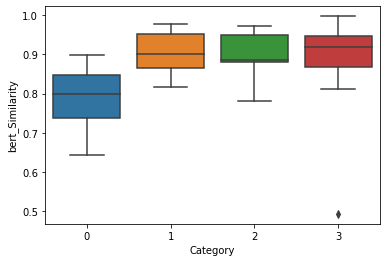

In [ ]:
box_plot=sns.boxplot(x=bert_train_X['Category'],y=maxsim)
box_plot.set(xlabel='Category',ylabel='bert_Similarity')

In [ ]:
roc_auc_score(bert_train_y,maxsim)

0.8923076923076922

In [ ]:
fpr_bert,tpr_bert,threshold_bert = roc_curve(bert_train_y,maxsim)
print("fpr:",fpr_bert,"\n")
print("tpr:",tpr_bert,"\n")
print("threshold",threshold_bert,"\n")



fpr: [0.         0.         0.         0.03846154 0.03846154 0.07692308
 0.07692308 0.11538462 0.11538462 0.19230769 0.19230769 0.26923077
 0.26923077 0.38461538 0.38461538 0.42307692 0.42307692 0.46153846
 0.46153846 0.65384615 0.65384615 1.         1.        ] 

tpr: [0.    0.025 0.5   0.5   0.675 0.675 0.75  0.75  0.8   0.8   0.85  0.85
 0.875 0.875 0.9   0.9   0.925 0.925 0.95  0.95  0.975 0.975 1.   ] 

threshold [1.99694175 0.99694175 0.90128958 0.89899945 0.88203967 0.88159883
 0.8737359  0.87130082 0.86867434 0.8664614  0.86318392 0.85218328
 0.84485579 0.82675433 0.82551241 0.82221812 0.81746203 0.81538278
 0.8113153  0.79129899 0.78165698 0.64334059 0.49334747] 



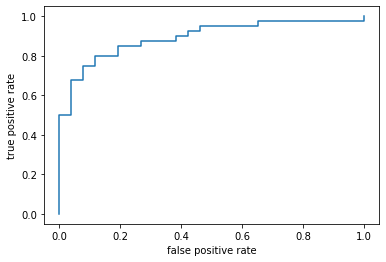

In [ ]:

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.plot(fpr_bert,tpr_bert)

In [ ]:
max(maxsim)

0.9969417452812195

In [ ]:
# get the best threshold using Youden’s J statistic.
J_bert = tpr_bert - fpr_bert
ix = np.argmax(J_bert)
best_thresh_bert = threshold_bert[ix]
print('Best Threshold=%f' % (best_thresh_bert))

Best Threshold=0.868674


In [ ]:
bert_train_Y_Pred=np.where(maxsim>best_thresh_bert,1,0)
bert_train_Y_Pred

array([0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1])

In [ ]:
# training accuracy
bert_accuracy_train= accuracy_score(bert_train_y,bert_train_Y_Pred)
print("Training Accuracy:",bert_accuracy_train)

Training Accuracy: 0.8181818181818182


### Testing

In [ ]:
bert_test_simarray=np.empty((len(bert_test_X),len(orig)))
for i in (range(len(orig))):
    for j in tqdm(range(len(bert_test_X))):
        bert_test_simarray[j][i]=similarity(bert_test_X,orig,j,i)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:05<00:00,  2.26s/it]


In [ ]:
bert_test_simarray 

array([[0.19466853, 0.45687789, 0.69255197, 0.1222981 , 0.17537305],
       [0.29609007, 0.33407614, 0.94247234, 0.23143694, 0.17474328],
       [0.23104067, 0.11958656, 0.16382185, 0.78691584, 0.19472618],
       [0.28829041, 0.22189261, 0.19324875, 0.15634508, 0.86149454],
       [0.89666092, 0.17606683, 0.22728781, 0.1827376 , 0.34142083],
       [0.32073644, 0.3642084 , 0.88964951, 0.22565614, 0.22860195],
       [0.27591902, 0.3663002 , 0.99456966, 0.21335067, 0.19559762],
       [0.26620939, 0.35567927, 0.98613077, 0.21369024, 0.19176552],
       [0.07465333, 0.38125321, 0.45801204, 0.44575116, 0.14809321],
       [0.30359778, 0.42196625, 0.93356872, 0.20345907, 0.19792877],
       [0.17388307, 0.9287402 , 0.41882098, 0.09682153, 0.18476839],
       [0.1295024 , 0.77948189, 0.32390124, 0.06383672, 0.1849943 ],
       [0.21222405, 0.39675188, 0.73838824, 0.15407236, 0.11645646],
       [0.34065211, 0.18533312, 0.18276688, 0.1867256 , 0.85810047],
       [0.1855444 , 0.91847348, 0.

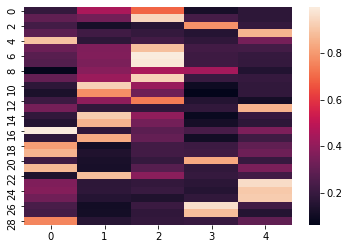

In [ ]:
ax=sns.heatmap(bert_test_simarray)

In [ ]:
bert_max_test_sim=bert_test_simarray.max(axis=1)
bert_max_test_sim

array([0.69255197, 0.94247234, 0.78691584, 0.86149454, 0.89666092,
       0.88964951, 0.99456966, 0.98613077, 0.45801204, 0.93356872,
       0.9287402 , 0.77948189, 0.73838824, 0.85810047, 0.91847348,
       0.86402494, 0.99625057, 0.84021515, 0.81265152, 0.86439866,
       0.83735001, 0.87310374, 0.88689756, 0.9593634 , 0.9119522 ,
       0.91861278, 0.96376401, 0.88462371, 0.76211542])

In [ ]:
test_plagsim=bert_max_test_sim[np.where(bert_test_y==1)]
test_plagsim

array([0.94247234, 0.89666092, 0.88964951, 0.99456966, 0.98613077,
       0.93356872, 0.9287402 , 0.91847348, 0.86402494, 0.99625057,
       0.87310374, 0.88689756, 0.9593634 , 0.9119522 , 0.91861278,
       0.96376401, 0.88462371])

In [ ]:
test_non_plagsim= bert_max_test_sim[np.where(bert_test_y==0)]
test_non_plagsim

array([0.69255197, 0.78691584, 0.86149454, 0.45801204, 0.77948189,
       0.73838824, 0.85810047, 0.84021515, 0.81265152, 0.86439866,
       0.83735001, 0.76211542])

<AxesSubplot:xlabel='Category'>

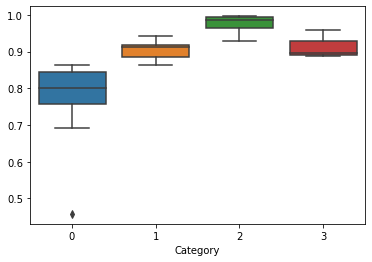

In [ ]:
sns.boxplot(x=bert_test_X["Category"],y=bert_max_test_sim)

In [ ]:
roc_auc_score(bert_test_y,bert_max_test_sim)

0.9950980392156863

In [ ]:
fpr,tpr,threshold = roc_curve(bert_test_y,bert_max_test_sim)
print("fpr:",fpr,"\n")
print("tpr:",tpr,"\n")
print("threshold",threshold,"\n")
print(len(threshold_bert))
print(len(bert_test_y))

fpr: [0.         0.         0.         0.08333333 0.08333333 1.        ] 

tpr: [0.         0.05882353 0.94117647 0.94117647 1.         1.        ] 

threshold [1.99625057 0.99625057 0.87310374 0.86439866 0.86402494 0.45801204] 

23
29


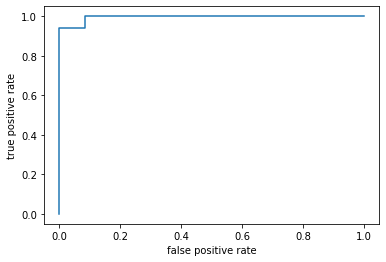

In [ ]:
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.plot(fpr,tpr)

In [ ]:
bert_test_Y_Pred=np.where(bert_max_test_sim>best_thresh_bert,1,0)
bert_test_Y_Pred

array([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0])

In [ ]:
bert_test_accuracy= accuracy_score(bert_test_y,bert_test_Y_Pred)
bert_test_accuracy

0.9655172413793104

### Performance of BERT wrt categories

In [ ]:
bert_train_y_cat_1=bert_train_y[bert_train_X['Category']==0]
bert_train_y_Pred_cat_1=bert_train_Y_Pred[bert_train_X['Category']==0]
#2
bert_train_y_cat_2=bert_train_y[bert_train_X['Category']==1]
bert_train_y_Pred_cat_2=bert_train_Y_Pred[bert_train_X['Category']==1]
#3
bert_train_y_cat_3=bert_train_y[bert_train_X['Category']==2]
bert_train_y_Pred_cat_3=bert_train_Y_Pred[bert_train_X['Category']==2]
#4
bert_train_y_cat_4=bert_train_y[bert_train_X['Category']==3]
bert_train_y_Pred_cat_4=bert_train_Y_Pred[bert_train_X['Category']==3]


In [ ]:
# training accuracy
bert_train_acc_cat_1=accuracy_score(bert_train_y_cat_1,bert_train_y_Pred_cat_1)
print("Train Accuracy for bert in category 1= ",bert_train_acc_cat_1)
bert_train_acc_cat_2=accuracy_score(bert_train_y_cat_2,bert_train_y_Pred_cat_2)
print("Train Accuracy for bert in category 2= ",bert_train_acc_cat_2)
bert_train_acc_cat_3=accuracy_score(bert_train_y_cat_3,bert_train_y_Pred_cat_3)
print("Train Accuracy for bert in category 3= ",bert_train_acc_cat_3)
bert_train_acc_cat_4=accuracy_score(bert_train_y_cat_4,bert_train_y_Pred_cat_4)
print("Train Accuracy for bert in category 4= ",bert_train_acc_cat_4)

Train Accuracy for bert in category 1=  0.8846153846153846
Train Accuracy for bert in category 2=  0.6
Train Accuracy for bert in category 3=  0.9285714285714286
Train Accuracy for bert in category 4=  0.75


In [ ]:
bert_test_y_cat_1=bert_test_y[bert_test_X['Category']==0]
bert_test_y_Pred_cat_1=bert_test_Y_Pred[bert_test_X['Category']==0]
#2
bert_test_y_cat_2=bert_test_y[bert_test_X['Category']==1]
bert_test_y_Pred_cat_2=bert_test_Y_Pred[bert_test_X['Category']==1]
#3
bert_test_y_cat_3=bert_test_y[bert_test_X['Category']==2]
bert_test_y_Pred_cat_3=bert_test_Y_Pred[bert_test_X['Category']==2]
#4
bert_test_y_cat_4=bert_test_y[bert_test_X['Category']==3]
bert_test_y_Pred_cat_4=bert_test_Y_Pred[bert_test_X['Category']==3]


In [ ]:
bert_test_acc_cat_1=accuracy_score(bert_test_y_cat_1,bert_test_y_Pred_cat_1)
print("Test Accuracy for bert in category 1= ",bert_test_acc_cat_1)
bert_test_acc_cat_2=accuracy_score(bert_test_y_cat_2,bert_test_y_Pred_cat_2)
print("Test Accuracy for bert in category 2 = ",bert_test_acc_cat_2)
bert_test_acc_cat_3=accuracy_score(bert_test_y_cat_3,bert_test_y_Pred_cat_3)
print("Test Accuracy for bert in category 3 = ",bert_test_acc_cat_3)
bert_test_acc_cat_4=accuracy_score(bert_test_y_cat_4,bert_test_y_Pred_cat_4)
print("Test Accuracy for bert in category 4 = ",bert_test_acc_cat_4)

Test Accuracy for bert in category 1=  1.0
Test Accuracy for bert in category 2 =  0.8888888888888888
Test Accuracy for bert in category 3 =  1.0
Test Accuracy for bert in category 4 =  1.0


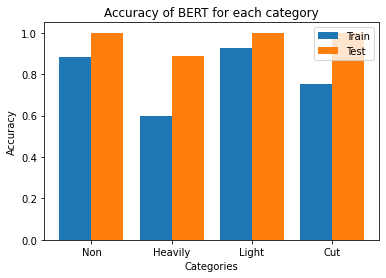

In [ ]:
  
X = ['Non','Heavily','Light','Cut']
Train_Accuracy = [bert_train_acc_cat_1,bert_train_acc_cat_2,bert_train_acc_cat_3,bert_train_acc_cat_4]
Test_Accuracy = [bert_test_acc_cat_1,bert_test_acc_cat_2,bert_test_acc_cat_3,bert_test_acc_cat_4]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Train_Accuracy, 0.4, label = 'Train')
plt.bar(X_axis + 0.2, Test_Accuracy, 0.4, label = 'Test')
  
plt.xticks(X_axis, X)
plt.xlabel("Categories")
plt.ylabel("Accuracy")
plt.title("Accuracy of BERT for each category")
plt.legend()
plt.bar.
plt.show()

## Applying Word2vec

In [ ]:
model = "C:/Users/fahan/Desktop/CENTELLA/NLP/NLP/model.bin"

word_vectors = gensim.models.KeyedVectors.load_word2vec_format(model, binary=True)
print(word_vectors)

KeyedVectors<vector_size=300, 199430 keys>


In [ ]:
data.head()

,File,Task,Category,Class,Text
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,2,1,the vector space model also called term vector...
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...


In [ ]:
X = answers.drop(columns='Class')
y = answers['Class']
w2v_train_X,w2v_test_X,w2v_train_y,w2v_test_y = train_test_split(X,y,test_size=0.3,stratify=y,random_state=10)


In [ ]:

stop_words=stopwords.words('english')
def w2vec_distance(query,source,query_index,source_index):
    list_1=nltk.pos_tag(nltk.word_tokenize(query['Text'].iloc[query_index]),tagset="universal")
    #print(list_1)
    query_list=[tuples[0]+'_'+tuples[1] for tuples in list_1 if tuples[0] not in stop_words] 
    #print(query_list)
    list_2=nltk.pos_tag(nltk.word_tokenize(source['Text'].iloc[source_index]),tagset="universal")
    #print(list_2)
    source_list=[tuples[0]+'_'+tuples[1] for tuples in list_2 if tuples[0] not in stop_words] 
    #print(source_list)
    dist=word_vectors.wmdistance(query_list,source_list)
    return dist

In [ ]:
 w2vec_distance(answers,orig,5,0)

0.9985037750098273

In [ ]:
w2vec_dist_array=np.empty((len(w2v_train_X),len(orig)))
for i in (range(len(orig))):
    for j in tqdm(range(len(w2v_train_X))):
        w2vec_dist_array[j][i]=w2vec_distance(w2v_train_X,orig,j,i)

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:16<00:00,  4.10it/s]


In [ ]:
w2vec_dist_array

array([[1.1044805 , 1.16186796, 1.09465447, 1.10039788, 1.01295229],
       [0.5619483 , 1.15032277, 1.12407243, 1.10049826, 1.07280055],
       [1.07048101, 1.1309754 , 1.09601598, 1.07836718, 0.71909746],
       [1.10771908, 1.12514922, 1.09731526, 0.78660976, 1.08347306],
       [1.11174944, 0.83360023, 1.10428433, 1.12687299, 1.12580667],
       [1.06202075, 1.12464356, 1.03026108, 1.04276788, 0.46503755],
       [1.12838049, 1.10497939, 0.84298804, 1.06637687, 1.10863802],
       [1.09754498, 1.09854747, 0.80998722, 1.04344207, 1.0745847 ],
       [1.10441643, 0.92203154, 1.06051917, 1.13988015, 1.088554  ],
       [1.10227691, 1.13877149, 1.03528875, 1.06519902, 0.60031425],
       [1.06695397, 1.12736884, 1.04855049, 0.51623839, 1.07527566],
       [0.57538489, 1.11714173, 1.02961283, 1.09622804, 1.06058284],
       [0.71674044, 1.15337016, 1.11284566, 1.11513664, 1.05512405],
       [1.11072027, 0.86681501, 1.06298619, 1.12681758, 1.02926508],
       [1.11319824, 0.80094003, 1.

In [ ]:
train_min_dist = w2vec_dist_array.min(axis=1)
train_min_dist

array([1.01295229, 0.5619483 , 0.71909746, 0.78660976, 0.83360023,
       0.46503755, 0.84298804, 0.80998722, 0.92203154, 0.60031425,
       0.51623839, 0.57538489, 0.71674044, 0.86681501, 0.80094003,
       0.23406452, 0.98979116, 0.41055547, 0.87162401, 0.79064018,
       0.60805802, 0.69910901, 0.70872217, 0.99850378, 0.02712835,
       0.84245715, 0.89944252, 0.50091144, 0.69128076, 0.85193986,
       0.82524543, 0.55111581, 0.66766297, 1.0658559 , 0.61066212,
       0.61599971, 0.94921696, 0.83696087, 0.19333116, 0.80358221,
       0.68514659, 0.66833124, 0.46126252, 0.6802024 , 0.40886815,
       0.90583359, 1.06322623, 0.84657546, 0.7587044 , 0.81876543,
       0.83012074, 0.0591857 , 0.96928749, 0.89917478, 0.80508425,
       0.89432105, 0.48882995, 1.01177342, 0.8721931 , 0.78029919,
       0.31457139, 0.61777603, 0.06972083, 0.60958092, 0.33475559,
       0.76242993])

In [ ]:
dist_scaler=MinMaxScaler().fit(train_min_dist.reshape(-1,1))

In [ ]:
w2v_train_min_dist_norm=dist_scaler.transform(train_min_dist.reshape(-1,1))
w2v_train_min_dist_norm

array([[0.94906883],
       [0.51487991],
       [0.66616998],
       [0.73116517],
       [0.77640367],
       [0.42158235],
       [0.78544147],
       [0.75367104],
       [0.86153793],
       [0.55181544],
       [0.47087424],
       [0.52781553],
       [0.66390084],
       [0.80838008],
       [0.74496116],
       [0.19922084],
       [0.92677123],
       [0.36913156],
       [0.81300979],
       [0.73504533],
       [0.5592705 ],
       [0.64692677],
       [0.65618152],
       [0.93515901],
       [0.        ],
       [0.78493037],
       [0.83979112],
       [0.45611873],
       [0.63939039],
       [0.79405953],
       [0.76836037],
       [0.5044513 ],
       [0.61665316],
       [1.        ],
       [0.56177751],
       [0.56691609],
       [0.88770979],
       [0.77963901],
       [0.16000617],
       [0.74750483],
       [0.63348492],
       [0.61729651],
       [0.41794807],
       [0.62872507],
       [0.36750715],
       [0.84594391],
       [0.99746837],
       [0.788

In [ ]:
train_w2v_similarity=1-w2v_train_min_dist_norm
train_w2v_similarity

array([[5.09311730e-02],
       [4.85120086e-01],
       [3.33830021e-01],
       [2.68834828e-01],
       [2.23596326e-01],
       [5.78417649e-01],
       [2.14558533e-01],
       [2.46328961e-01],
       [1.38462066e-01],
       [4.48184558e-01],
       [5.29125760e-01],
       [4.72184465e-01],
       [3.36099156e-01],
       [1.91619919e-01],
       [2.55038836e-01],
       [8.00779162e-01],
       [7.32287711e-02],
       [6.30868441e-01],
       [1.86990210e-01],
       [2.64954673e-01],
       [4.40729504e-01],
       [3.53073229e-01],
       [3.43818477e-01],
       [6.48409902e-02],
       [1.00000000e+00],
       [2.15069627e-01],
       [1.60208881e-01],
       [5.43881271e-01],
       [3.60609610e-01],
       [2.05940470e-01],
       [2.31639632e-01],
       [4.95548701e-01],
       [3.83346844e-01],
       [1.11022302e-16],
       [4.38222492e-01],
       [4.33083908e-01],
       [1.12290208e-01],
       [2.20360991e-01],
       [8.39993834e-01],
       [2.52495169e-01],


[Text(0.5, 0, 'Category'), Text(0, 0.5, 'Word2vec Similarity')]

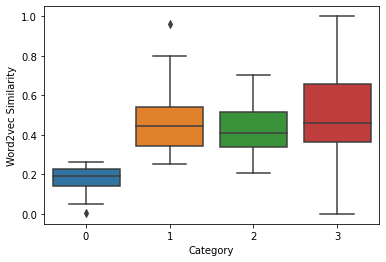

In [ ]:
box_plot_1=sns.boxplot(x=w2v_train_X['Category'],y=train_w2v_similarity.ravel())
box_plot_1.set(xlabel='Category',ylabel='Word2vec Similarity')

In [ ]:
roc_auc_score(w2v_train_y,train_w2v_similarity.ravel())

0.9423076923076923

In [ ]:
w2v_fpr,w2v_tpr,w2v_threshold = roc_curve(w2v_train_y,train_w2v_similarity.ravel())
print("fpr:",fpr,"\n")
print("tpr:",tpr,"\n")
print("threshold",threshold,"\n")


fpr: [0.         0.         0.         0.08333333 0.08333333 1.        ] 

tpr: [0.         0.05882353 0.94117647 0.94117647 1.         1.        ] 

threshold [1.99625057 0.99625057 0.87310374 0.86439866 0.86402494 0.45801204] 



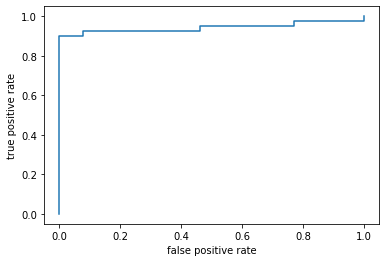

In [ ]:
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.plot(w2v_fpr,w2v_tpr)

In [ ]:
# get the best threshold using Youden’s J statistic.
J_w2v = w2v_tpr - w2v_fpr
ix = np.argmax(J_w2v)
best_thresh_w2v = w2v_threshold[ix]
print('Best Threshold=%f' % (best_thresh_w2v))

Best Threshold=0.268835


In [ ]:
w2v_train_Y_Pred=np.where(train_w2v_similarity.ravel()>best_thresh_w2v,1,0)
w2v_train_Y_Pred

array([0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
# training accuracy
w2v_accuracy_train= accuracy_score(w2v_train_y,w2v_train_Y_Pred)
print("Training Accuracy:",w2v_accuracy_train)

Training Accuracy: 0.9242424242424242


In [ ]:
w2v_test_dist_array=np.empty((len(w2v_test_X),len(orig)))
for i in (range(len(orig))):
    for j in tqdm(range(len(w2v_test_X))):
        w2v_test_dist_array[j][i]=w2vec_distance(w2v_test_X,orig,j,i)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:07<00:00,  4.09it/s]


In [ ]:
w2v_test_dist_array

array([[1.15315784, 1.12676431, 0.87020582, 1.09292184, 1.12543289],
       [1.11110392, 1.08072367, 0.57214843, 1.03858422, 1.0352418 ],
       [1.19015426, 1.16257605, 1.17401094, 1.01430978, 1.13556549],
       [1.08484107, 1.11020735, 1.07499397, 1.06575777, 0.86276514],
       [0.5716124 , 1.15815649, 1.09818666, 1.11293007, 1.07493071],
       [1.05454099, 1.10413585, 0.45176786, 1.04426056, 1.06425206],
       [1.04066083, 1.0848445 , 0.1794837 , 1.04644408, 1.04036438],
       [1.05572659, 1.08634355, 0.27163678, 1.07101974, 1.05331538],
       [1.11708169, 1.06078513, 1.06503538, 1.05118741, 1.09917183],
       [1.09360377, 1.07210562, 0.4003684 , 1.08272381, 1.06987557],
       [1.084624  , 0.50879873, 1.09639796, 1.07956768, 1.09626012],
       [1.09538173, 0.92750917, 1.08638975, 1.1159043 , 1.07317211],
       [1.12120382, 1.13667266, 0.90373342, 1.13209029, 1.14404648],
       [1.05662551, 1.10327017, 1.03758573, 1.04283304, 0.80465759],
       [1.14841693, 0.78390443, 1.

In [ ]:
min_w2v_test_dist_array=w2v_test_dist_array.min(axis=1)
min_w2v_test_dist_array

array([0.87020582, 0.57214843, 1.01430978, 0.86276514, 0.5716124 ,
       0.45176786, 0.1794837 , 0.27163678, 1.05118741, 0.4003684 ,
       0.50879873, 0.92750917, 0.90373342, 0.80465759, 0.78390443,
       0.5839522 , 0.09469193, 0.86698811, 0.96910216, 0.93801442,
       0.85864377, 0.81469672, 0.75552371, 0.42230922, 0.78068323,
       0.59372962, 0.30410426, 0.59559792, 0.93943776])

In [ ]:
test_min_dist_norm=dist_scaler.transform(min_w2v_test_dist_array.reshape(-1,1))
test_w2vec_sim=1-test_min_dist_norm
test_w2vec_sim

array([[0.18835553],
       [0.47530026],
       [0.04962429],
       [0.1955188 ],
       [0.4758163 ],
       [0.5911926 ],
       [0.85332501],
       [0.76460773],
       [0.01412159],
       [0.64067569],
       [0.53628804],
       [0.13318865],
       [0.15607796],
       [0.25145989],
       [0.27143929],
       [0.46393657],
       [0.93495543],
       [0.19145327],
       [0.0931464 ],
       [0.12307508],
       [0.1994865 ],
       [0.24179504],
       [0.29876187],
       [0.61955291],
       [0.27454039],
       [0.45452369],
       [0.73335076],
       [0.45272505],
       [0.1217048 ]])

<AxesSubplot:xlabel='Category'>

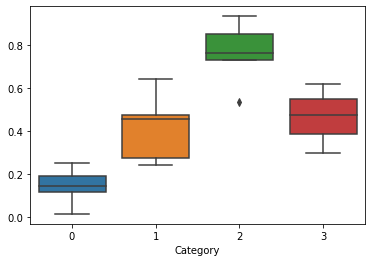

In [ ]:
sns.boxplot(x=w2v_test_X['Category'],y=test_w2vec_sim.ravel())

In [ ]:
roc_auc_score(w2v_test_y,test_w2vec_sim)

0.9950980392156863

In [ ]:
w2v_test_Y_Pred=np.where(test_w2vec_sim.ravel()>best_thresh_w2v,1,0)
w2v_test_Y_Pred

array([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0])

In [ ]:
w2v_test_y,w2v_test_Y_Pred

(72    0
 47    1
 23    0
 44    0
 50    1
 17    1
 42    1
 2     1
 93    0
 32    1
 91    1
 76    0
 22    0
 64    0
 21    1
 61    1
 20    1
 71    0
 40    0
 65    0
 38    0
 90    1
 36    1
 49    1
 39    1
 89    1
 48    1
 53    1
 0     0
 Name: Class, dtype: int32,
 array([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 0]))

In [ ]:
# test accuracy
w2v_test_accuracy= accuracy_score(w2v_test_y,w2v_test_Y_Pred)
print("Test Accuracy:",w2v_test_accuracy)

Test Accuracy: 0.9655172413793104


### Performance of word2vec wrt categories

In [ ]:
w2v_test_y_cat_1=w2v_test_y[w2v_test_X['Category']==0]
w2v_test_y_Pred_cat_1=w2v_test_Y_Pred[w2v_test_X['Category']==0]
#2
w2v_test_y_cat_2=w2v_test_y[w2v_test_X['Category']==1]
w2v_test_y_Pred_cat_2=w2v_test_Y_Pred[w2v_test_X['Category']==1]
#3
w2v_test_y_cat_3=w2v_test_y[w2v_test_X['Category']==2]
w2v_test_y_Pred_cat_3=w2v_test_Y_Pred[w2v_test_X['Category']==2]
#4
w2v_test_y_cat_4=w2v_test_y[w2v_test_X['Category']==3]
w2v_test_y_Pred_cat_4=w2v_test_Y_Pred[w2v_test_X['Category']==3]


In [ ]:
w2v_train_y_cat_1=w2v_train_y[w2v_train_X['Category']==0]
w2v_train_y_Pred_cat_1=w2v_train_Y_Pred[w2v_train_X['Category']==0]
#2
w2v_train_y_cat_2=w2v_train_y[w2v_train_X['Category']==1]
w2v_train_y_Pred_cat_2=w2v_train_Y_Pred[w2v_train_X['Category']==1]
#3
w2v_train_y_cat_3=w2v_train_y[w2v_train_X['Category']==2]
w2v_train_y_Pred_cat_3=w2v_train_Y_Pred[w2v_train_X['Category']==2]
#4
w2v_train_y_cat_4=w2v_train_y[w2v_train_X['Category']==3]
w2v_train_y_Pred_cat_4=w2v_train_Y_Pred[w2v_train_X['Category']==3]

In [ ]:
# test accuracy
w2v_test_accuracy_cat_1= accuracy_score(w2v_test_y_cat_1,w2v_test_y_Pred_cat_1)
print("Test Accuracy Category 1:",w2v_test_accuracy_cat_1)
w2v_test_accuracy_cat_2= accuracy_score(w2v_test_y_cat_2,w2v_test_y_Pred_cat_2)
print("Test Accuracy Category 2:",w2v_test_accuracy_cat_2)
w2v_test_accuracy_cat_3= accuracy_score(w2v_test_y_cat_3,w2v_test_y_Pred_cat_3)
print("Test Accuracy Category 3:",w2v_test_accuracy_cat_3)
w2v_test_accuracy_cat_4= accuracy_score(w2v_test_y_cat_4,w2v_test_y_Pred_cat_4)
print("Test Accuracy Category 4:",w2v_test_accuracy_cat_4)

Test Accuracy Category 1: 1.0
Test Accuracy Category 2: 0.8888888888888888
Test Accuracy Category 3: 1.0
Test Accuracy Category 4: 1.0


In [ ]:
# train accuracy
w2v_train_acc_cat_1=accuracy_score(w2v_train_y_cat_1,w2v_train_y_Pred_cat_1)
print("Train Accuracy Category 1:",w2v_train_acc_cat_1)
w2v_train_acc_cat_2=accuracy_score(w2v_train_y_cat_2,w2v_train_y_Pred_cat_2)
print("Train Accuracy Category 2:",w2v_train_acc_cat_2)
w2v_train_acc_cat_3=accuracy_score(w2v_train_y_cat_3,w2v_train_y_Pred_cat_3)
print("Train Accuracy Category 3:",w2v_train_acc_cat_3)
w2v_train_acc_cat_4=accuracy_score(w2v_train_y_cat_4,w2v_train_y_Pred_cat_4)
print("Train Accuracy Category 4:",w2v_train_acc_cat_4)


Train Accuracy Category 1: 1.0
Train Accuracy Category 2: 0.9
Train Accuracy Category 3: 0.8571428571428571
Train Accuracy Category 4: 0.875


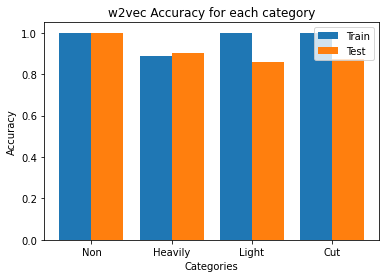

In [ ]:
  
X =  ['Non','Heavily','Light','Cut']
Train_Accuracy = [w2v_test_accuracy_cat_1,w2v_test_accuracy_cat_2,w2v_test_accuracy_cat_3,w2v_test_accuracy_cat_4]
Test_Accuracy = [w2v_train_acc_cat_1,w2v_train_acc_cat_2,w2v_train_acc_cat_3,w2v_train_acc_cat_4]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Train_Accuracy, 0.4, label = 'Train')
plt.bar(X_axis + 0.2, Test_Accuracy, 0.4, label = 'Test')
  
plt.xticks(X_axis, X)
plt.xlabel("Categories")
plt.ylabel("Accuracy")
plt.title("w2vec Accuracy for each category")
plt.legend()
plt.show()